# Class-Conditioned Diffusion Model



In [2]:
#%%capture
!pip install diffusers[training]==0.11.1
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/challengers.zip'

# Directory to extract the contents to
extract_to_directory = '/content/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("Extraction complete.")


Extraction complete.


In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-fingerprint-conditional-128_v1'  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [ ]:
import os
from PIL import Image
from datasets import Dataset, DatasetDict

def load_images_from_folders(folder_path):
    images = []
    labels = []

    # Function to recursively walk through folders
    def walk_through_folders(folder_path, class_label):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".png"):
                    images.append(os.path.join(root, file))
                    labels.append(class_label)

    # Specify the class folders A to H
    class_folders = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

    # Enumerate through class folders
    for class_label, class_name in enumerate(class_folders):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            # Recursively walk through class folders
            walk_through_folders(class_folder, class_label)

    return images, labels

# Example usage
folder_path = "/content/challengers/"
images, labels = load_images_from_folders(folder_path)
print(list(set(labels)))  # Print distinct labels

# Create a DatasetDict with class labels
dataset_dict = {'image': [], 'label': []}

# Convert images to PIL format batch-wise
for image_path, label in zip(images, labels):
    with Image.open(image_path) as img:
        dataset_dict['image'].append(img)
        dataset_dict['label'].append(label)

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict(dataset_dict)
})

# Print the number of rows and features for the train split
print(dataset)


[0, 1, 2, 3, 4, 5, 6, 7]
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13630
    })
})


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13630
    })
})

(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)
(0, 255)
L
(512, 512)


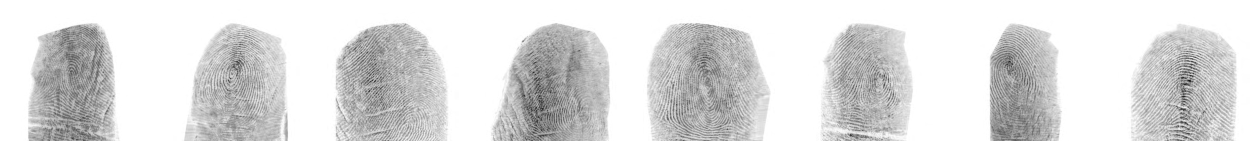

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:8]['image']):
    print(image.getextrema())
    print(image.mode)
    print(image.size)
    axs[i].imshow(image,cmap='gray')
    axs[i].set_axis_off()
fig.show()

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("L")) for image in examples["image"]]
    labels = examples["label"]
    return {"images": images, "labels": labels}


dataset.set_transform(transform)

Shape of image 1: torch.Size([1, 128, 128])
1.0 -0.4117646813392639
Shape of image 2: torch.Size([1, 128, 128])
1.0 -0.3803921341896057
Shape of image 3: torch.Size([1, 128, 128])
1.0 -0.45098036527633667
Shape of image 4: torch.Size([1, 128, 128])
1.0 -0.5529412031173706


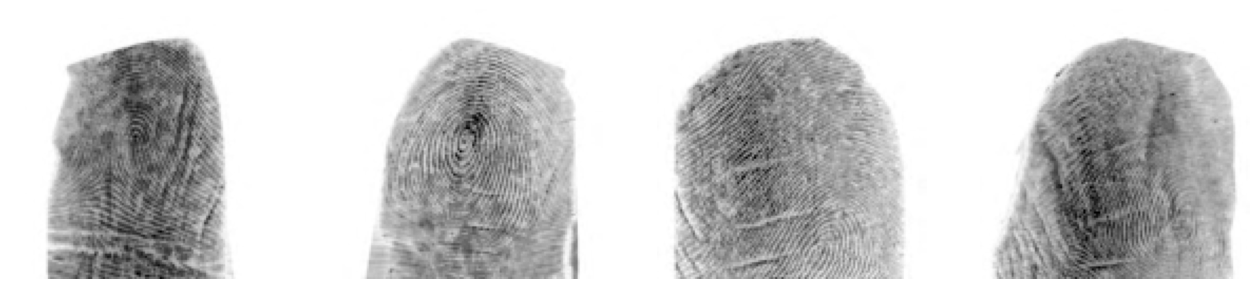

In [ ]:
import torch
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["images"]):
    print("Shape of image {}: {}".format(i+1, image.shape))
    image.numpy
    axs[i].imshow(image.permute(1,2,0).numpy() / 2 + 0.5,cmap='gray')
    axs[i].set_axis_off()
    print(torch.max(image).item(),torch.min(image).item())
fig.show()

## Creating a Class-Conditioned UNet

class conditioning is done  as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

 class_emb_size is set to 4,try different values! b

In [ ]:
import torch.nn as nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=8, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=config.image_size,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
        ),
        up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 128, 128) and class_cond is now (bs, 4, 128, 128)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 128, 128)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 128, 128)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling



In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=config.train_batch_size, shuffle=True)

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
model = ClassConditionedUnet()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
sample_image = dataset['train'][0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 1, 128, 128])


In [ ]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from diffusers import DDPMPipeline
from PIL import Image
import math
import os
import numpy as np
import matplotlib.pyplot as plt



def evaluate(config,model, epoch):

    # Prepare random x to start from, plus some desired labels y
    torch.manual_seed(config.seed)
    x = torch.randn(8, 1, config.image_size,config.image_size).to(device)
    class_labels = torch.tensor([[i]*1 for i in range(8)]).flatten().to(device)

    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

        # Get model pred
        with torch.no_grad():
            residual = model(x, t, class_labels)

        # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample

    # Reshape x to (batch_size, height, width) for visualization
    x_vis = x.squeeze().cpu().numpy()

    # Assuming x_vis is a batch of images, you can arrange them in a grid for visualization
    batch_size, height, width = x_vis.shape
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    # Plot each image in the grid
    for i in range(batch_size):
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(x_vis[i], cmap='gray')  # Assuming grayscale images, change the cmap if needed
        ax.axis('off')

    # Remove empty subplots if batch size is not a perfect square
    for i in range(batch_size, grid_size * grid_size):
        fig.delaxes(axes.flatten()[i])
    plt.show()
    # Save the image grid
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    plt.savefig(f"{test_dir}/{epoch:04d}.png")
    plt.close()  # Close the figure to release memory

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
import torch.nn.functional as F
from tqdm.auto import tqdm
from pathlib import Path
import os
from transformers import AutoConfig
import itertools

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            class_labels = batch['labels']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps,class_labels)
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            #pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            unet=accelerator.unwrap_model(model)
            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config,accelerator.unwrap_model(model), epoch)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    os.makedirs(config.output_dir, exist_ok=True)

                    # Save the model state dict
                    torch.save(model.state_dict(), os.path.join(config.output_dir, "conditional_model_weights.pth"))


In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Once training finishes, we can sample some images feeding in different labels as our conditioning:

In [ ]:
evaluate(config,model, 50)

0it [00:00, ?it/s]

In [ ]:
from accelerate import Accelerator
import torch

# Initialize the accelerator
accelerator = Accelerator()

# Path to the saved state dictionary
path = "/content/ddpm-fingerprint-conditional-128_v1/conditional_model_weights.pth"

# Initialize the model
model_50 = ClassConditionedUnet()

# Unwrap the model if it's wrapped by the accelerator
model_50 = accelerator.unwrap_model(model_50)

# Load the state dictionary
state_dict = torch.load(path, map_location=torch.device('cpu'))  # Load onto CPU

# Load the state dictionary into the model
model_50.load_state_dict(state_dict)

# Move the model to the appropriate device (CPU or GPU)
model_50 = model_50.to(accelerator.device)

# If you want to keep the model on CPU:
# model_50 = model_50.to('cpu')


0it [00:00, ?it/s]

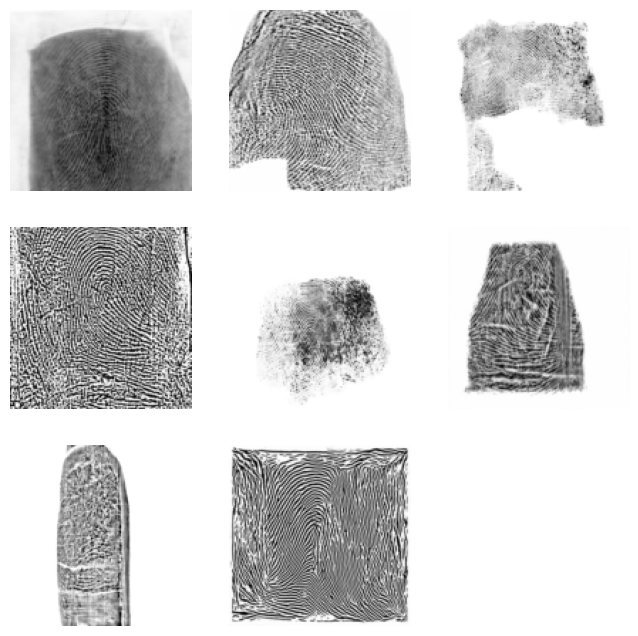

In [ ]:
evaluate(config,model_50, 51)